# Age prediction on structural data from HBN

## Load and Prepare the data 

Start out impoting the classes and functions we might need

In [1]:
import numpy as np
#from xgboost import XGBClassifier
#from xgboost import XGBRegressor

#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

import csv
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm


Loading the csv's as panda dataframe

In [3]:
# Loading Pheno 
all_pheno = pd.read_csv('Pheno_complete.csv')
#print(all_pheno.shape) = (366, 3)
#sex = all_pheno.Sex
#age = all_pheno.Age.values # converting to numpy array
#print(age)

# to get only the values: age.values

# Loading cortical thickness
cortical_thickness = pd.read_csv('Cortical_thickness_allRegion.csv')
#print(cortical_thickness.shape) = (1458, 63)
#print(cortical_thickness)
#print(list(cortical_thickness))
cortical_thickness_HCP = cortical_thickness[cortical_thickness['sub-type'].str.endswith('HCP')]
cortical_thickness_HCP_run01 = cortical_thickness[cortical_thickness['sub-type'].str.endswith('HCP_run-01')]
cortical_thickness_HCP_all = pd.concat([cortical_thickness_HCP,cortical_thickness_HCP_run01])
#print(cortical_thickness_HCP_all.shape) = (372, 63)

column_names = list(cortical_thickness)
column_names = column_names[0:62]
#print(column_names)

cortical_thickness_VNavNorm = cortical_thickness[cortical_thickness['sub-type'].str.endswith('VNavNorm')]
cortical_thickness_VNavNorm_run01 = cortical_thickness[cortical_thickness['sub-type'].str.endswith('VNavNorm_run-01')]
cortical_thickness_VNavNorm_all = pd.concat([cortical_thickness_VNavNorm,cortical_thickness_VNavNorm_run01])
#print(cortical_thickness_VNavNorm_all.shape) = (428, 63)

# area
area = pd.read_csv('area_allRegion.csv')
#print(area.shape) = (1458, 63)
area_HCP = area[area['subid'].str.endswith('HCP')]
area_HCP_run01 = area[area['subid'].str.endswith('HCP_run-01')]
area_HCP_all = pd.concat([area_HCP,area_HCP_run01])
#print(area_HCP_all.shape) = (372, 63)

area_VNavNorm = area[area['subid'].str.endswith('VNavNorm')]
area_VNavNorm_run01 = area[area['subid'].str.endswith('VNavNorm_run-01')]
area_VNavNorm_all = pd.concat([area_VNavNorm,area_VNavNorm_run01])
#print(area_VNavNorm_all.shape) = (428, 63)


# loading volume
volume = pd.read_csv('Volume_allRegion.csv')
#print(volume.subid)
volume_HCP = volume[volume['subid'].str.endswith('HCP')]
volume_HCP_run01 = volume[volume['subid'].str.endswith('HCP_run-01')]
volume_HCP_all = pd.concat([volume_HCP,volume_HCP_run01])
#print(area_HCP_all.shape)  = (372, 63)

volume_VNavNorm = volume[volume['subid'].str.endswith('VNavNorm')]
volume_VNavNorm_run01 = volume[volume['subid'].str.endswith('VNavNorm_run-01')]
volume_VNavNorm_all = pd.concat([volume_VNavNorm,volume_VNavNorm_run01])
#print(volume_VNavNorm_all.shape) = (430, 169)



Now we need to get a list of subjects that are in all datasets 
As it looks like, the dataset with the phenotypical data is the most restrictive, with 366 rows. 


In [4]:
#print(all_pheno)

#initialize a list
#blah = {columns=['subjid']}
list_subj = pd.DataFrame(columns=['subjid'])
#print(list_subj)


#print(cortical_thickness_HCP_all['sub-type'].str[:7])

cortical_thick_subjid_HCP = cortical_thickness_HCP_all['sub-type'].str[:7]
cortical_thick_subjid_vNav = cortical_thickness_VNavNorm_all['sub-type'].str[:7]

#print(cortical_thick)    
#print(cortical_thick)
#a = cortical_thick.str.contains('5069025')
#print(a)

# Going though a loop of the subject list that has phenotypical data and seeing which subjects match in the list that also have cortical thickness. 
for subjid in all_pheno['subid'].str[-7:]:
    #print(subjid)
    #print(type(cortical_thickness_HCP_all['sub-type'].str[:7]))
       
    if (cortical_thick_subjid_HCP.str.contains(subjid).any() and  cortical_thick_subjid_vNav.str.contains(subjid).any()):
        #print([subjid])
        list_subj=list_subj.append({'subjid': subjid},ignore_index=True)
        #print(list_subj)
    else:
        a=1
        #print("Nope")
    
#print("This is the list of subjects that have age and cortical thickness: ")
print(list_subj.shape)


(327, 1)


Now need to create a list of subects based on sex (males and females)

In [5]:
list_subj_male = pd.DataFrame(columns=['subid','Age',"Sex"])
list_subj_female = pd.DataFrame(columns=['subid','Age',"Sex"])
#print(list_subj['subjid'].str[:])


#print(all_pheno.loc[:])

#blah = all_pheno[all_pheno['subid'] == ("sub-" + "5098010")]

for subjid in list_subj['subjid'].str[:]:
    blah = all_pheno[all_pheno['subid'] == ("sub-" + subjid)]
    
    
    #print(type(blah['Sex'].str[:].to_string()))
    #print((blah['Sex'].str.contains("M")).any())
    
    if (blah['Sex'].str.contains("M")).any():
        #print("Male")
        list_subj_male = pd.concat([list_subj_male, blah],ignore_index=True)  
    else:
        #print("Female")
        list_subj_female = pd.concat([list_subj_female, blah],ignore_index=True) 

#print(list_subj_male.shape) 
#print(list_subj_female.shape) 



 Now matching the list of males and females with the cortical thickness values

In [6]:
#print(cortical_thickness_HCP_all)
#print(cortical_thickness_VNavNorm_all)

# initiating the dataframe
cortical_thickness_HCP_male = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)
cortical_thickness_HCP_female = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)
cortical_thickness_vNav_male = pd.DataFrame(data=None, columns=cortical_thickness_VNavNorm_all.columns)
cortical_thickness_vNav_female = pd.DataFrame(data=None, columns=cortical_thickness_VNavNorm_all.columns)


# looping though males first
for subjid in list_subj_male['subid'].str[4:]:
    #print(subjid)
    # Getting the MPRAGE data
    blah = cortical_thickness_HCP_all[cortical_thickness_HCP_all["sub-type"].str.contains(subjid)]
    cortical_thickness_HCP_male = pd.concat([cortical_thickness_HCP_male, blah],ignore_index=True) 
    
    # Now the vNav
    blah = cortical_thickness_VNavNorm_all[cortical_thickness_VNavNorm_all["sub-type"].str.contains(subjid)]
    cortical_thickness_vNav_male = pd.concat([cortical_thickness_vNav_male, blah],ignore_index=True) 
    
    
    
# now looping through the females
for subjid in list_subj_female['subid'].str[4:]:
    #print(subjid)
    # Getting the MPRAGE data
    blah = cortical_thickness_HCP_all[cortical_thickness_HCP_all["sub-type"].str.contains(subjid)]
    cortical_thickness_HCP_female = pd.concat([cortical_thickness_HCP_female, blah],ignore_index=True) 
    
    # Now the vNav
    blah = cortical_thickness_VNavNorm_all[cortical_thickness_VNavNorm_all["sub-type"].str.contains(subjid)]
    cortical_thickness_vNav_female = pd.concat([cortical_thickness_vNav_female, blah],ignore_index=True) 

    
# now save everthing in csv files
list_subj_male.to_csv(r'list_pheno_males.csv', index = None, header=True)
list_subj_female.to_csv(r'list_pheno_females.csv', index = None, header=True)


cortical_thickness_HCP_male.to_csv(r'list_cortical_thickness_HCP_male.csv', index = None, header=True)
cortical_thickness_vNav_male.to_csv(r'list_cortical_thickness_vNav_male.csv', index = None, header=True)
cortical_thickness_HCP_female.to_csv(r'list_cortical_thickness_HCP_female.csv', index = None, header=True)
cortical_thickness_vNav_female.to_csv(r'list_cortical_thickness_vNav_female.csv', index = None, header=True)




Total number os subjects:   
list_subj_male = 209   
list_subj_female = 118 


## Now going to do some statistics (ANCOVA)
## !!! REMEMBER - this needs to be changed to a repeted samples ANCOVA

Now just organizing the data to easily be used

In [9]:
# for males, combine the HCP vNav and pheno dataframes

for name in column_names[0:62]:
    #print(name)
    cortical_thickness_HCP_male.rename(columns={name: name + "_HCP"}, inplace = True)
    cortical_thickness_vNav_male.rename(columns={name: name + "_vNav"}, inplace = True)
    

cortical_thickness_male = pd.merge(cortical_thickness_HCP_male,cortical_thickness_vNav_male, how='outer',  left_index=True, right_index=True)
all_male = pd.merge(list_subj_male,cortical_thickness_male, how='outer',  left_index=True, right_index=True)

#print(all_male.shape)

#for females, combine the HCP vNav and pheno dataframes
for name in column_names[0:62]:
    #print(name)
    cortical_thickness_HCP_female.rename(columns={name: name + "_HCP"}, inplace = True)
    cortical_thickness_vNav_female.rename(columns={name: name + "_vNav"}, inplace = True)
    

cortical_thickness_female = pd.merge(cortical_thickness_HCP_female,cortical_thickness_vNav_female, how='outer',  left_index=True, right_index=True)
all_female = pd.merge(list_subj_female,cortical_thickness_female, how='outer',  left_index=True, right_index=True)

#print(all_female.shape)
#all_male.describe()

#all_female.describe()

#all_male[['ctx-lh-caudalanteriorcingulate_HCP', 'ctx-lh-caudalanteriorcingulate_vNav']].plot(kind='box')
# Running paired t-tests
for name in column_names[0:62]:
    #stats.ttest_rel(all_male['ctx-lh-caudalanteriorcingulate_HCP'], all_male['ctx-lh-caudalanteriorcingulate_vNav'])
    t_statistic, p_value = stats.ttest_rel(all_male[name + '_HCP'], all_male[name + '_vNav'])
    #print(name + ", " + str(t_statistic) + ", " + str(p_value) )

    


for name in column_names[0:62]:
    #stats.ttest_rel(all_male['ctx-lh-caudalanteriorcingulate_HCP'], all_male['ctx-lh-caudalanteriorcingulate_vNav'])
    t_statistic, p_value = stats.ttest_rel(all_female[name + '_HCP'], all_female[name + '_vNav'])
    #print(name + ", " + str(t_statistic) + ", " + str(p_value) )
    
    
    
    

Now lets see if there is an age effect on the difference between measurements

20.466575


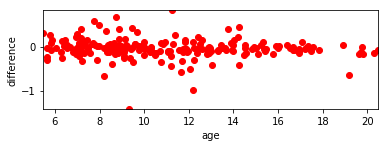

In [25]:
# need to build another database, but now with the differences between MPRAGE and vNav

# copy the columns of a dataframe 
cortical_thickness_diff_male = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)

#cortical_thickness_HCP_all['ctx-lh-caudalanteriorcingulate'] 

#a = all_male[column_names[0] + "_HCP"] - all_male[column_names[0] + "_vNav"]
#print(a)
#print(list(all_male))

#print(column_names[61])


for name in column_names[0:62]:
    cortical_thickness_diff_male[name] = all_male[name + "_HCP"] - all_male[name + "_vNav"]

#print(cortical_thickness_diff_male[column_names[0]])
diff = np.array(cortical_thickness_diff_male[column_names[2]])

age = np.array(all_male['Age'])

#print(column_names[64]) # 64 is age
print(age.max())

plt.figure()
plt.subplot(211)
plt.plot(age,diff,'ro')
plt.axis([age.min(), age.max(), diff.min(), diff.max()])
plt.xlabel('age')
plt.ylabel('difference')
plt.show()
#    name + "_vNav"
#Example on how to do regression ! 
#http://www.alexsalo.xyz/ancova-comparing-regression-slopes/





Now trying to plot the difference

-0.021409803091466822
0.7583129710974696
62
[-0.02815045 -0.01153717 -0.0162381  -0.02803813 -0.01718424 -0.01876536
 -0.01972192 -0.01669912 -0.02810799 -0.01934368 -0.01382635 -0.01151652
 -0.01069683 -0.0236076  -0.02146191 -0.02069049 -0.02799447 -0.02019552
 -0.02109592 -0.02645362 -0.02636556 -0.02704406 -0.02223888 -0.02096338
 -0.02776918 -0.02163465 -0.02038401 -0.02793439 -0.02319169 -0.02245804
 -0.02807136 -0.01080244 -0.0260033  -0.02709026 -0.0281505  -0.02516981
 -0.02684849 -0.01314314 -0.02601395 -0.02364175 -0.02760642 -0.02656601
 -0.02186321 -0.02506625 -0.02002076 -0.01553182 -0.02163493 -0.02200531
 -0.02716826 -0.02661192 -0.02193339 -0.02785092 -0.01323315 -0.02717593
 -0.01409906 -0.0231454  -0.02498857 -0.02814908 -0.02665656 -0.02461004
 -0.02415237 -0.02062117 -0.02657319 -0.02682521 -0.01358065 -0.02808529
 -0.02113564 -0.01938041 -0.01324147 -0.02735347 -0.02262972 -0.02808604
 -0.02792366 -0.02762708 -0.02370626 -0.02761245 -0.02632306 -0.02094286
 -0.028

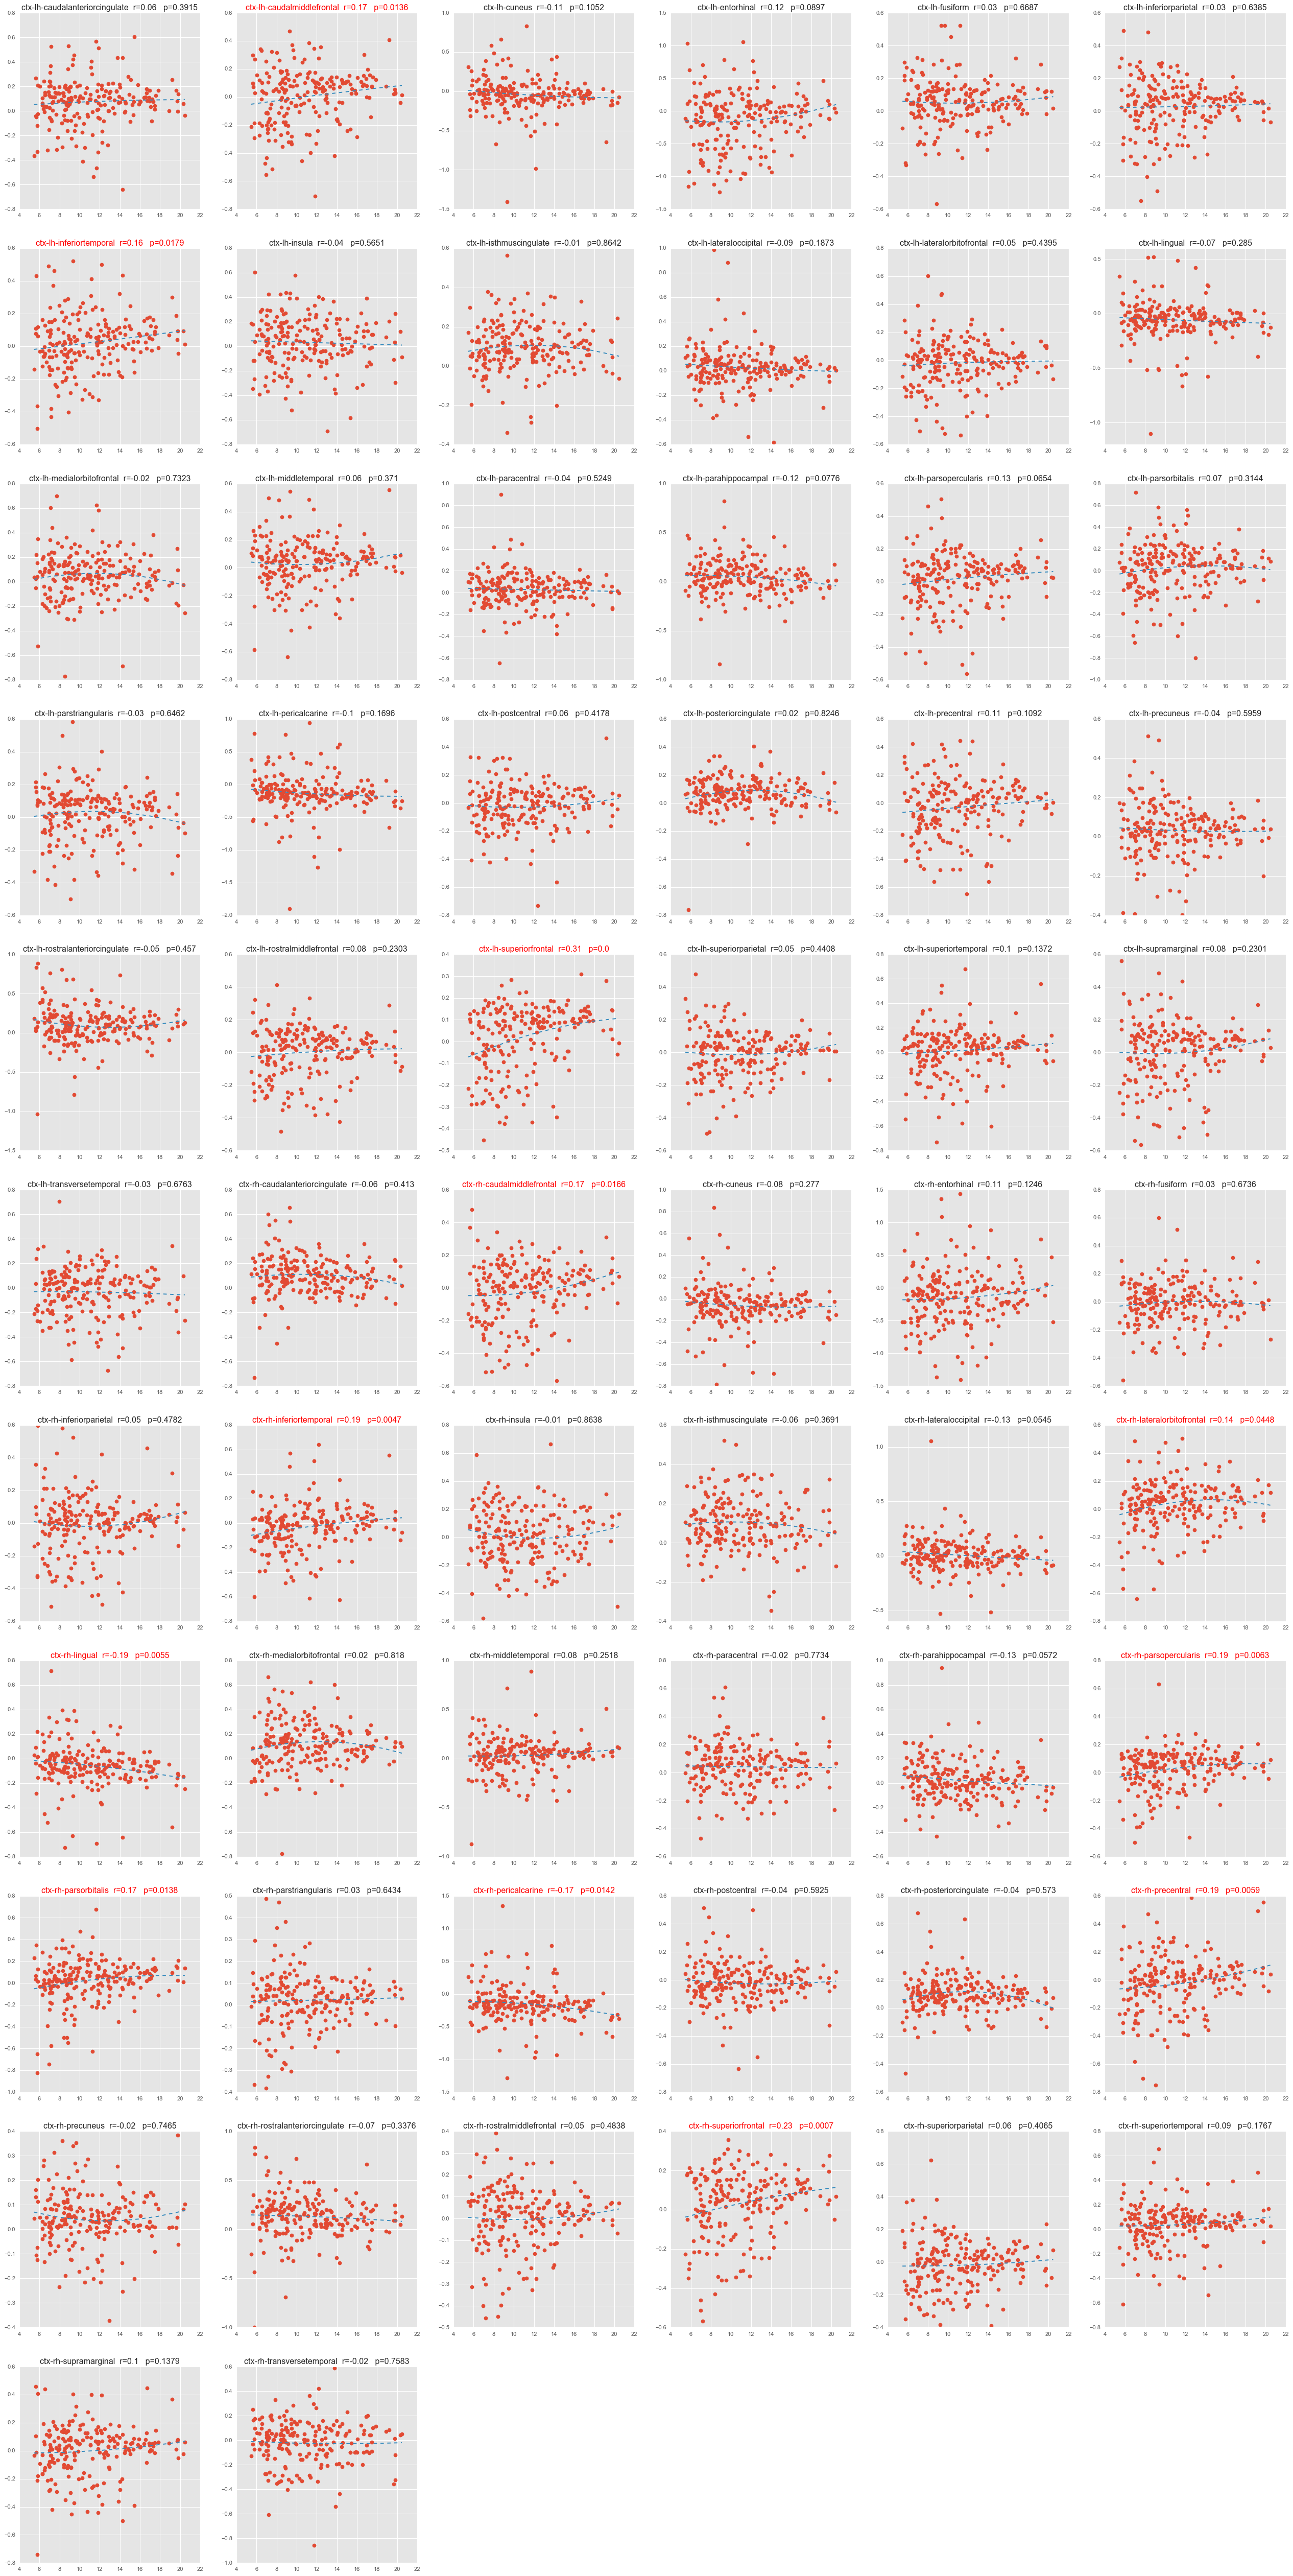

In [175]:
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

num = 32

age = np.array(all_male['Age'])
#plt.style.use('seaborn')
plt.style.use('ggplot')

#fig = go.Figure()

fig = plt.figure(figsize=(40, 78))

for num in np.r_[0: len(column_names)]:
    diff = np.array(cortical_thickness_diff_male[column_names[num]])
    #diff = np.array(cortical_thickness_diff_male[name])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(age,diff)
    
    #line = slope*age+intercept
 
    fit = np.polyfit(age,diff,2)
    fit_fn = np.poly1d(fit)
    
    plt.subplot(11, 6 , num+1 )
    plt.plot(age,diff, 'o', np.sort(age), fit_fn(np.sort(age)), '--')
    ax = plt.gca()
    #ax.set_facecolor((0.898, 0.898, 0.898))
    
    #plt.subplot(11, 6 , num+1 )
    #plt.plot(age,diff,'o', age, line)
    if p_value<0.05:
        plt.title(column_names[num] + "  r=" + str(np.around(r_value, decimals=2)) + "   p=" + str(np.around(p_value, decimals=4)),color='r')
        
    else:
        plt.title(column_names[num] + "  r=" + str(np.around(r_value, decimals=2)) + "   p=" + str(np.around(p_value, decimals=4)))
    
                  
    #ax = plt.gca()
    #ax.set_facecolor((0.898, 0.898, 0.898))
    #fig = plt.gcf()
    

plt.savefig("bubbleplot.png", transparent=True, dpi=120)
#fig.write_image("fig1.png")
#py.plot_mpl(fig, filename='linear-Fit-with-matplotlib')

print(r_value)
print(p_value)


print(len(column_names))
print(fit_fn(age))

Now another option to plot

(4, 22)

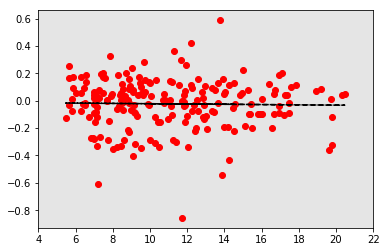

In [113]:

import numpy as np
import matplotlib.pyplot as plt

#x = [1,2,3,4]
#y = [3,5,7,10] # 10, not 9, so the fit isn't perfect

fit = np.polyfit(age,diff,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(age,diff, 'ro', age, fit_fn(age), '--k')
ax = plt.gca()
ax.set_facecolor((0.898, 0.898, 0.898))

plt.xlim(4, 22)
#plt.ylim(0, 12)



## The rest is just examples for plotting

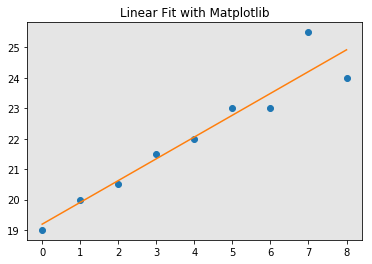

In [24]:
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats


xi = arange(0,9)
A = array([ xi, ones(9)])

# (Almost) linear sequence
y = [19, 20, 20.5, 21.5, 22, 23, 23, 25.5, 24]

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

plt.plot(xi,y,'o', xi, line)
pylab.title('Linear Fit with Matplotlib')
ax = plt.gca()
ax.set_facecolor((0.898, 0.898, 0.898))
fig = plt.gcf()
#py.plot_mpl(fig, filename='linear-Fit-with-matplotlib')

In [173]:
# scratch
print(age)
print(np.sort(age))


[ 5.463723  5.636208  5.643851  5.663016  5.784052  5.805384  5.846452
  5.851813  6.02715   6.279603  6.304243  6.306525  6.400068  6.468514
  6.498631  6.522701  6.544718  6.545174  6.693018  6.826602  6.928473
  6.960757  6.966803  6.975017  6.985398  6.996463  6.999201  7.062628
  7.078485  7.081222  7.095482  7.131074  7.174309  7.174309  7.193588
  7.253821  7.272872  7.317134  7.382386  7.459046  7.470568  7.494638
  7.585671  7.664955  7.697353  7.738877  7.810061  7.872461  7.878393
  7.974332  7.995779  8.198836  8.211955  8.296828  8.335272  8.387177
  8.428815  8.445242  8.448094  8.48072   8.510495  8.537873  8.546087
  8.546657  8.581679  8.63963   8.672484  8.699292  8.721195  8.797969
  8.806068  8.858658  8.860825  8.874515  8.882728  8.948437  8.959958
  9.006502  9.074948  9.077686  9.0778    9.126853  9.159822  9.203057
  9.208532  9.310289  9.342687  9.430755  9.436344  9.48825   9.507529
  9.567191  9.610997  9.665639  9.745608  9.750627  9.863449  9.928587
  9.96

(0, 12)

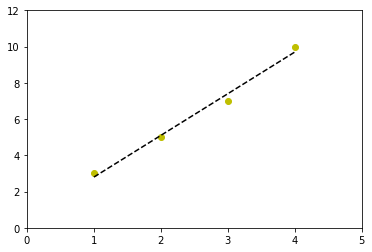

In [83]:
import numpy as np
import matplotlib.pyplot as plt

x = [1,2,3,4]
y = [3,5,7,10] # 10, not 9, so the fit isn't perfect

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.xlim(0, 5)
plt.ylim(0, 12)